### Notebook stuck?
Note that because of Jupyter and Plotly issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.

In [4]:
# Download scenes using python3 projects/AriaSyntheticEnvironment/aria_synthetic_environments_downloader.py --set train --scene-ids 0-9 --cdn-file aria_synthetic_environments_dataset_download_urls.json --output-dir projectaria_tools_ase_data --unzip True
# conda create -n aria python=3.10 
# pip install -r requirements.txt
# conda activate aria

In [5]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from pathlib import Path
from PIL import Image
from scipy.spatial.transform import Rotation as R

DATASET_ROOT = "/Users/sahithyaravi/Documents/projectaria_tools/projectaria_tools_ase_data"  # Specify your own dataset path
SCENE_ID = 1  # Select a scene id

dataset_path = Path(DATASET_ROOT)
print("Chosen ASE data path: ", dataset_path)
print(f"Using Scene {SCENE_ID} for these examples")

scene_path = dataset_path / str(SCENE_ID)

Chosen ASE data path:  /Users/sahithyaravi/Documents/projectaria_tools/projectaria_tools_ase_data
Using Scene 1 for these examples


In [6]:
from code_snippets.readers import read_points_file, read_trajectory_file, read_language_file

# Load scene point cloud using read_points_file()
points_path = scene_path / "semidense_points.csv.gz"
points = read_points_file(points_path)

# Load a trajectory using read_trajectory_file() 
trajectory_path = scene_path / "trajectory.csv"
trajectory = read_trajectory_file(trajectory_path)

# Load a scene command language using read_language_file()
language_path = scene_path / "ase_scene_language.txt"
entities = read_language_file(language_path)

from code_snippets.interpreter import language_to_bboxes

# Interpret scene commands into 3D Boxes
entity_boxes = language_to_bboxes(entities)

Loaded point cloud with 598583 points.
Loaded trajectory with 373 device poses.
Loaded scene commands with a total of 14 entities.
Scene contains:
  wall: 8
  door: 2
  window: 4


In [7]:
import sys
sys.path.append("/Users/sahithyaravi/Documents/projectaria_tools")
from projectaria_tools.projects import ase

def transform_3d_points(transform, points):
    N = len(points)
    points_h = np.concatenate([points, np.ones((N, 1))], axis=1)
    transformed_points_h = (transform @ points_h.T).T
    transformed_points = transformed_points_h[:, :-1]
    return transformed_points
    
# Load camera calibration
device = ase.get_ase_rgb_calibration()

# Load the trajectory using read_trajectory_file() 
trajectory_path = scene_path / "trajectory.csv"
trajectory = read_trajectory_file(trajectory_path)

# Load scene point cloud using read_points_file()
points_path = scene_path / "semidense_points.csv.gz"
points_world = read_points_file(points_path)

# Transform the points into the device coordinate frame
frame_idx = 0  # Select a frame index
T_world_from_device = trajectory["Ts_world_from_device"][frame_idx]
T_device_from_world = np.linalg.inv(T_world_from_device)
points_device = transform_3d_points(T_device_from_world, points_world)

# Transform the points into the RGB camera coordinate frame
T_device_from_camera = device.get_transform_device_camera().to_matrix()
T_camera_from_device = np.linalg.inv(T_device_from_camera)
points_device = transform_3d_points(T_camera_from_device, points_device)


Loaded trajectory with 373 device poses.
Loaded point cloud with 598583 points.


In [10]:
def random_bright_colormap(num_colors=1024):
    bright_colors = np.random.rand(num_colors, 3)
    bright_colors = (bright_colors + 1) / 2
    return colors.ListedColormap([c for c in bright_colors])

scene_path = dataset_path / str(SCENE_ID)

rgb_dir = scene_path / "rgb"
depth_dir = scene_path / "depth"
instance_dir = scene_path / "instances"

# Choose a random frame to plot from the scene's images
num_frames = len(list(rgb_dir.glob("*.jpg")))
frame_idx = np.random.randint(num_frames)

# Load images
frame_id = str(frame_idx).zfill(7)

rgb_path = rgb_dir / f"vignette{frame_id}.jpg"
depth_path = depth_dir / f"depth{frame_id}.png"
instance_path = instance_dir / f"instance{frame_id}.png"

rgb = Image.open(rgb_path)
depth = Image.open(depth_path)
instances = Image.open(instance_path)


# Part 0: Bird Eye View

In [11]:

from projectaria_tools.core.sophus import SE3
from projectaria_tools.core import calibration
from projectaria_tools.utils.rerun_helpers import ToTransform3D
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.image import InterpolationMethod

def rotate_se3_about_forward_axis(T_scene_camera, theta):
    """
    Rotates an SE3 matrix about its forward (z) axis by an angle theta.

    Parameters:
    T_scene_camera (numpy.ndarray): The original 4x4 SE3 matrix.
    theta (float): The angle by which to rotate about the z-axis (in radians).

    Returns:
    numpy.ndarray: The rotated 4x4 SE3 matrix.
    """
    # Extract the rotation part (3x3) from the SE3 matrix
    R_scene_camera = T_scene_camera.rotation().to_matrix()
    
    # Extract the translation part (3x1) from the SE3 matrix
    t_scene_camera = T_scene_camera.translation()
    
    # Create the rotation matrix for rotation about the z-axis
    R_z = R.from_euler('z', theta).as_matrix()
    
    # Apply the rotation to the original rotation part
    R_scene_camera_rotated = R_scene_camera @ R_z
    
    # Combine the rotated rotation part with the original translation part
    T_scene_camera_rotated = np.eye(4)
    T_scene_camera_rotated[:3, :3] = R_scene_camera_rotated
    T_scene_camera_rotated[:3, 3] = t_scene_camera
    
    return SE3.from_matrix(T_scene_camera_rotated)

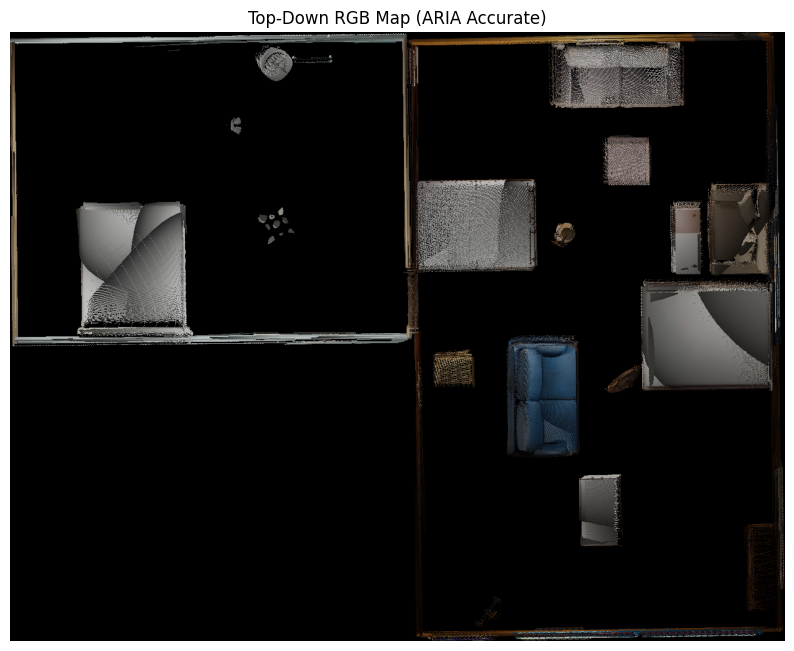

In [12]:

import cv2
def undistort_image(file_path, device, is_depth=False):
    
    if is_depth:
        raw_image = np.array(Image.open(file_path)).astype(np.float32)
    else:
        raw_image = Image.open(file_path)
    rectified_array = calibration.distort_by_calibration(raw_image, device, device, InterpolationMethod.BILINEAR)
    return rectified_array
#------------------------------
def render_topdown_from_projected(points_world, colors, grid_resolution=0.01):
    x, y, z = points_world[:, 0], points_world[:, 1], points_world[:, 2]
    valid = (z > 0.1) & (z < 2.5)
    x, y, colors = x[valid], y[valid], colors[valid]

    min_x, min_y = x.min(), y.min()
    max_x, max_y = x.max(), y.max()

    W = int(np.ceil((max_x - min_x) / grid_resolution))
    H = int(np.ceil((max_y - min_y) / grid_resolution))
    img = np.zeros((H, W, 3), dtype=np.uint8)

    xi = ((x - min_x) / grid_resolution).astype(int)
    yi = ((y - min_y) / grid_resolution).astype(int)

    img[H - yi - 1, xi] = colors
    return img

all_points = []
all_colors = []

T_Device_Cam = device.get_transform_device_camera()
image_size = device.get_image_size()
width, height = image_size[0], image_size[1]

rays = np.empty((height, width, 3))
for u in range(width):
    for v in range(height):
        ray = device.unproject([u, v])
        if ray is not None:
            ray = ray / np.linalg.norm(ray)
        rays[v, u] = ray

for frame_idx in range(0, num_frames, 10):
    frame_id = str(frame_idx).zfill(7)
    rgb_path = rgb_dir / f"vignette{frame_id}.jpg"
    depth_path = depth_dir / f"depth{frame_id}.png"
    if not rgb_path.exists() or not depth_path.exists():
        continue

    rgb = undistort_image(rgb_path, device, is_depth=False)
    depth = undistort_image(depth_path, device, is_depth=True)
    instances = undistort_image(instance_path, device)
    instance_array = np.array(instances)
    unique_instance_ids = np.unique(instance_array)

    rgb = np.rot90(np.array(rgb), 3)
    depth = np.rot90(np.array(depth).astype(np.float32), 3)
    instance_array = np.rot90(instance_array, 3)
    
    T_Scene_Device = trajectory["Ts_world_from_device"][frame_idx]
    T_Device_Cam_rot = rotate_se3_about_forward_axis(T_Device_Cam, 3 * np.pi / 2)
    T_Scene_Cam = T_Scene_Device @ T_Device_Cam_rot.to_matrix()

    valid_mask = (rays is not None) & (depth > 0)
    indices = np.argwhere(valid_mask)
    u_indices, v_indices = indices[:, 1], indices[:, 0]
    rays_selected = rays[v_indices, u_indices]
    depth_selected = depth[v_indices, u_indices] / 1000.0

    p_in_cam = (depth_selected[:, None] * rays_selected)
    p_in_scene = transform_3d_points(T_Scene_Cam, p_in_cam)

    colors = rgb[v_indices, u_indices]
    all_points.append(p_in_scene)
    all_colors.append(colors)

points_world = np.concatenate(all_points, axis=0)
colors = np.concatenate(all_colors, axis=0)
rgb_numpy = np.asarray(rgb)
instance_ids = instance_array[v_indices, u_indices]


topdown_img = render_topdown_from_projected(points_world, colors)
plt.figure(figsize=(10, 10))
plt.imshow(topdown_img)
plt.title("Top-Down RGB Map (ARIA Accurate)")
plt.axis("off")
plt.savefig("topdown_rgb_map_corrected.png", dpi=300)


# Part 1: 3D Plotting

In [ ]:
# Plot each modality together in 3D
from code_snippets.plotters import plot_point_cloud, plot_trajectory, plot_box_wireframe

plot_traces = []
# Create a trace for the pointcloud using plot_point_cloud()
plot_traces.append(plot_point_cloud(points))
# Create a trace for the trajectory using plot_trajectory()
plot_traces.append(plot_trajectory(trajectory))

# Create a trace for each entity box in the form of a wireframe using plot_box_wireframe()
for entity_box in entity_boxes:
    plot_traces.append(plot_box_wireframe(entity_box))

fig = go.Figure(data=plot_traces)
fig.update_layout(
    template="plotly_dark",
    scene={
        "xaxis": {"showticklabels": False, "title": ""},
        "yaxis": {"showticklabels": False, "title": ""},
        "zaxis": {"showticklabels": False, "title": ""},
    },
)
fig.show()



In [ ]:
# Alternatively, we include a plotting function that will handle all of the steps for you.
from code_snippets.plotters import plot_3d_scene

plot_3d_scene(
    language_path=language_path,
    points_path=points_path,
    trajectory_path=trajectory_path
)
# save as a gif

In [ ]:
# # Top-down
# fig.update_layout(scene_camera=dict(eye=dict(x=0., y=0., z=2.)))
# fig.write_image("top_view.png")

# # Front view
# fig.update_layout(scene_camera=dict(eye=dict(x=0., y=2., z=0.)))
# fig.write_image("front_view.png")

# # Side view
# fig.update_layout(scene_camera=dict(eye=dict(x=2., y=0., z=0.)))
# fig.write_image("side_view.png")

# Part 2: Loading and Plotting Images and Image Annotations

In [ ]:

# Note: Images are rotated to upright for visualization.
# However, the camera calibration is for the original orientation.
rgb_to_plot = rgb.rotate(-90, expand=True)
depth_to_plot = depth.rotate(-90, expand=True)
instances_to_plot = instances.rotate(-90, expand=True)

# Plot the images
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), dpi=300)
axes[0].imshow(rgb_to_plot)
axes[0].set_title("RGB Image")
axes[1].imshow(np.array(depth_to_plot), cmap="plasma")
axes[1].set_title("Metric Depth (mm)")
axes[2].imshow(np.array(instances_to_plot), cmap=random_bright_colormap())
axes[2].set_title("Instance Map")
for ax in axes:
    ax.axis("off")
plt.show()

# Part 3: Project Points into Images

In [ ]:


# Choose and load random frame to plot from the scene's images
num_frames = len(list(rgb_dir.glob("*.jpg")))
frame_idx = np.random.randint(num_frames)
frame_id = str(frame_idx).zfill(7)
rgb_path = rgb_dir / f"vignette{frame_id}.jpg"
rgb = Image.open(rgb_path)


# Project points into the image
points_image = []
depths = []
for point_device in points_device:
    point_image = device.project(point_device)
    if point_image is not None:
        points_image.append(point_image)
points_image = np.stack(points_image)

# Overlay projected points onto image
plt.imshow(rgb)
plt.scatter(points_image[:, 0], points_image[:, 1], s=0.01, alpha=0.3, c="#FFFFFF")
plt.axis("off")
plt.show()

In [ ]:
help(ase.get_ase_rgb_calibration())